Researchers put a trap and captured samples belonging to 23 different bears. After 10 days, they obtained 19 additional unique bears, of which 5 were previously identified in the first batch. Now estimate the number of unique bears in the region.

- Actual population: N
- Bears identified in the first session: K=23
- Bears identified in the second session: n=19
- Overlap: k=4

Suppose we're given N, K, n, what is the probability of getting a specific k?

The answer is (N choose k)(N - K choose n - k)/(N choose n). This is called a hypergeometric distribution.

Here's why:

- There are N choose n ways we can see the n individuals
- Out of which, we first pick the ks (overlapping individuals) out of the full population
- Then, the remaining n-k individuals are chosen from the remaining N-K members

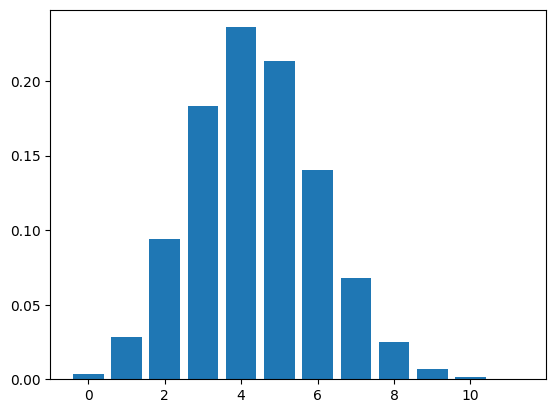

In [4]:
import numpy as np
from utils import Pmf
from scipy.stats import hypergeom

N = 100 # supposing N=100
K = 23
n = 19
ks = np.arange(12)
ps = hypergeom(N, K, n).pmf(ks)
Pmf(ps, ks).bar()

<Axes: >

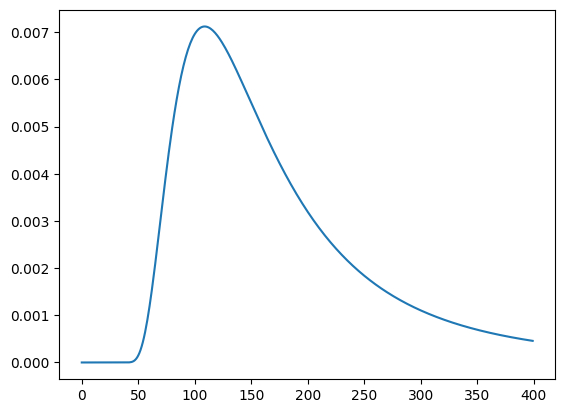

In [11]:
# Given the distribution probability of finding n given N, we can use
# bayesian method to find the distribution of N given n.

prior_N = Pmf(1, np.arange(400))
def update_hypergeom(prior, K, n, k):
    qs = prior.qs
    posterior = prior * hypergeom(qs, K, n).pmf(k)
    posterior.normalize()
    return posterior

posterior_N_hypergeom = update_hypergeom(prior_N, 23, 19, 4)
posterior_N_hypergeom.plot()

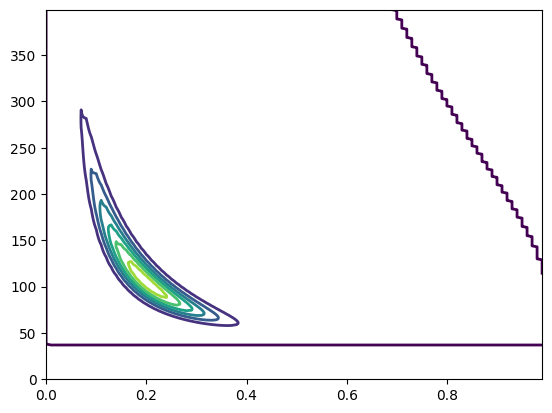

In [30]:
# The above model is simple enough. Let's consider a two parameter model
# - Number of bears: N
# - Probability of seeing a bear: p

# We also declare some variables:

k10 = 23 - 4 # num of bears observed in the first session but not the second
k01 = 19 - 4 # num of bears observed in the second session but not the first
k11 = 4 # num of bears observed in both sessions
# k00 = N - k10 - k01 - k11 # suppose we know N, k00 is the num of bears not observed.

# The probability of each case (k00, k01, k10, k11) is:
# (q*q, p*q, q*p, p*p) where q=1-p is the probability of not observing a bear

# Given the population count N, the probability of a case, the probability of the data is given
# by the multinomial distribution N!/Prod(x_i!) Prod(y_i ^ x_i)
# where x_i is the sequence of counts # and y_i is the sequence of probabilities

from scipy.stats import multinomial
from utils import make_joint, plot_contour

qs = np.linspace(0, 0.99, num=100)
prior_p = Pmf(1, qs, name='p')
prior_joint = make_joint(prior_p, prior_N)

def update_multinomial(prior, k10, k01, k11):
    prior_pmf = Pmf(prior.stack())
    likelihoods = prior_pmf.astype('float64')
    for N, p in prior_pmf.index:
        k00 = N - k10 - k01 - k11
        xs = [k00, k01, k10, k11]
        # note: sum(xs) must == N and sum(ps) must == 1
        q = 1 - p
        ys = [q*q, p*q, p*q, p*p]
        likelihoods[N, p] = multinomial.pmf(xs, N, ys)
    posterior = prior_pmf * likelihoods
    posterior.normalize()
    return posterior.unstack()

posterior_joint = update_multinomial(prior_joint, k10, k01, k11)
plot_contour(posterior_joint)

<Axes: >

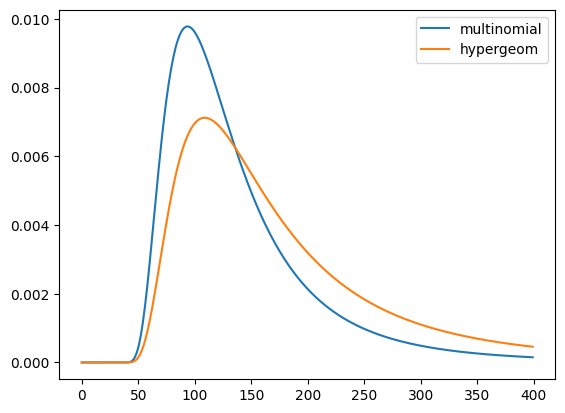

In [34]:
from utils import marginal
posterior_marginal_N = marginal(posterior_joint, 1)
posterior_marginal_N.plot(label="multinomial", legend=True)
posterior_N_hypergeom.plot(label="hypergeom", legend=True)

John D. Cook's Lincoln's index: the estimated number is E1xE2/S where E1 and E2 are the count of the two independent observation, and S is the count in common.

This chapter is all about the above two distributions:

- hypergeometric
- multinomial

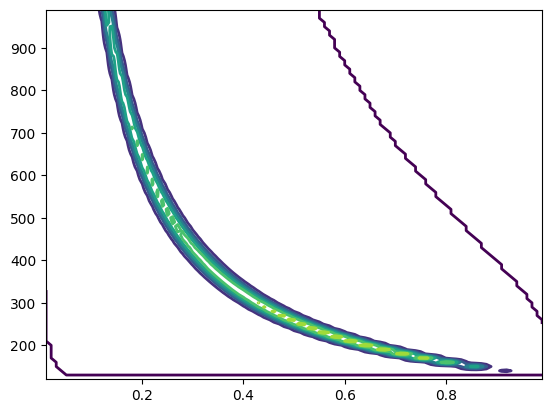

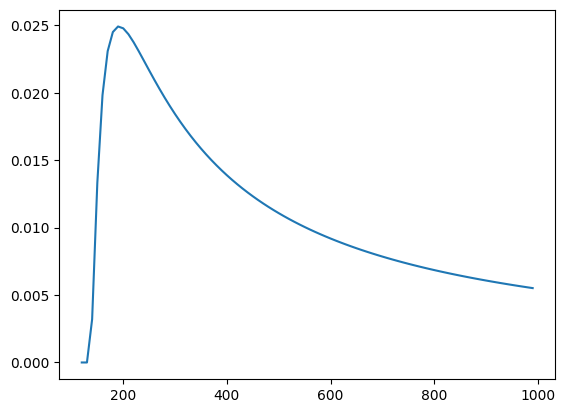

In [111]:
# exercise 15-1: two tests, one found 135 cases and another one found 122 cases.
# estimate the total counts.

# the difficult part is that the number of overlapped cases are not given in the problem
# description and it does specify which which method am i suppose to use. I'm going to
# assume a two parameter model: N and p, assuming the two tests all have the same probability p
# of finding out the cases.
%matplotlib inline

import pandas as pd
from scipy.stats import binom
import matplotlib.pyplot as plt

def ex_15_1(n1, n2):
    qs_N = np.arange(120, 1000, 10)
    qs_p = np.arange(0.01, 1.0, 0.01)
    index = pd.MultiIndex.from_product([qs_N, qs_p])
    prior = Pmf(pd.Series(1, index=index))
    likelihoods = prior.astype('float64')
    for N, p in prior.index:
        likelihoods[N, p] = binom.pmf(n1, N, p) * binom.pmf(n2, N, p)
    posterior = prior * likelihoods
    posterior.normalize()
    joint = posterior.unstack()
    plot_contour(joint)
    plt.show()
    posterior.marginal(0).plot()
    plt.show()

ex_15_1(135, 122)
# multinomial.pmf([3, 2], n=5, p=[0.9, 0.1])
#multinomial.pmf([3, 4], n=7, p=[0.4, 0.6])

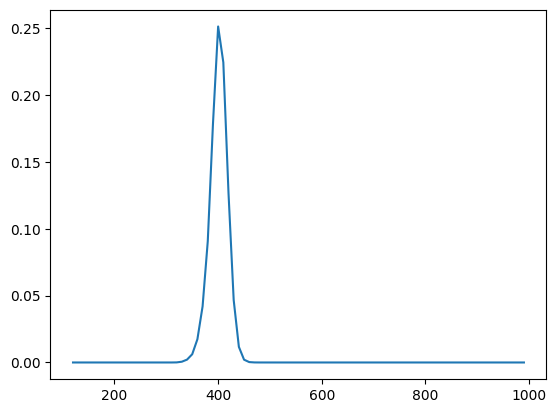

In [120]:
# Exercise 15-2: now the problem have given the overlapping counts. The problem is revised:
#
# three tests: P=135, Q=122, E=126.
# Overlaps: (k111=28, k110=21, k101=17, k100=69, k011=18, k010=55, k001=63, k000=unknown)
def ex_15_1(ks):
    qs_N = np.arange(120, 1000, 10)
    qs_p = np.arange(0.1, 1.0, 0.1)
    index = pd.MultiIndex.from_product([qs_N, qs_p, qs_p, qs_p])
    prior = Pmf(pd.Series(1, index=index))
    likelihoods = prior.astype('float64')
    sum_ks = sum(ks)
    for N, p1, p2, p3 in prior.index:
        q1, q2, q3 = 1-p1, 1-p2, 1-p3
        ps = [p1*p2*p3, p1*p2*q3, p1*q2*p3, p1*q2*q3,
    	      q1*p2*p3, q1*p2*q3, q1*q2*p3, q1*q2*q3]
        xs = ks + [N - sum_ks]
        likelihoods[N, p1, p2, p3] = multinomial.pmf(xs, N, ps)
    posterior = prior * likelihoods
    posterior.normalize()
    posterior.marginal(0).plot()

ex_15_1([28, 21, 17, 69, 18, 55, 63])